In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset

In [3]:
from sklearn.datasets import load_diabetes

# Load the Diabetes dataset
diabetes = load_diabetes()

# Convert to Pandas DataFrame
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target  # Add target column

In [5]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


* The Diabetes dataset from sklearn.datasets contains normalized feature values, meaning all the features (including age) are scaled before being provided in the dataset.
* The values you see are standardized between approximately -0.1 and 0.1

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


### Data Visualization

#### Histogram of Features

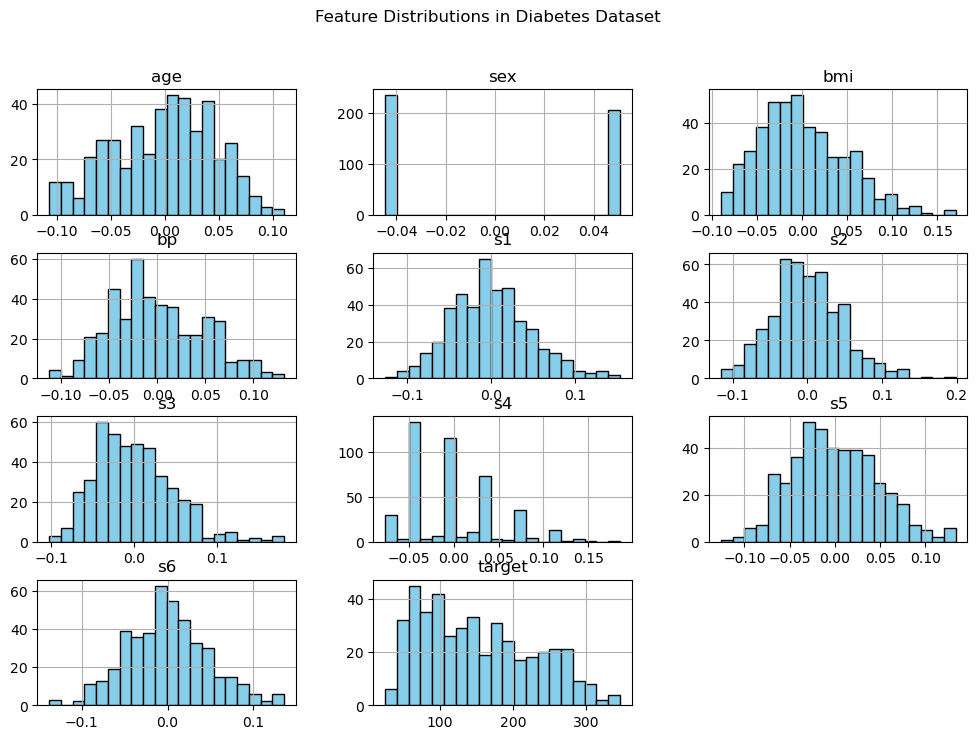

In [12]:
df.hist(figsize=(12, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions in Diabetes Dataset")
plt.show()

* Most features are approximately normally distributed, except s5 (which has skewness).
* The target variable (disease progression measure) appears to be continuous with a slightly skewed distribution.

#### Checking Distribution of Target Variable

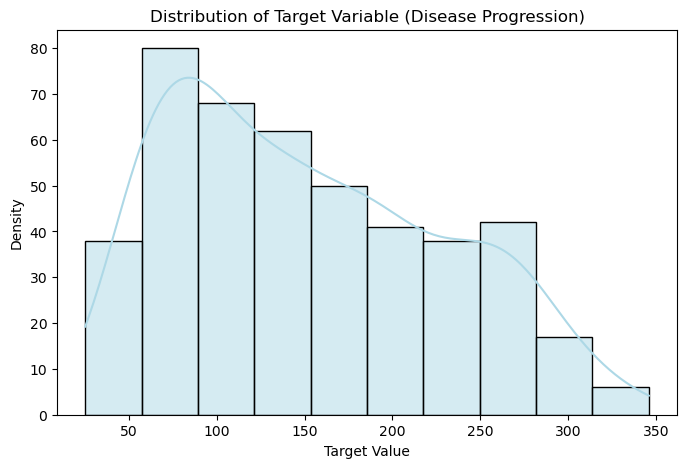

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df['target'], kde=True, color="lightblue")
plt.title("Distribution of Target Variable (Disease Progression)")
plt.xlabel("Target Value")
plt.ylabel("Density")
plt.show()

#### Checking for Correlations

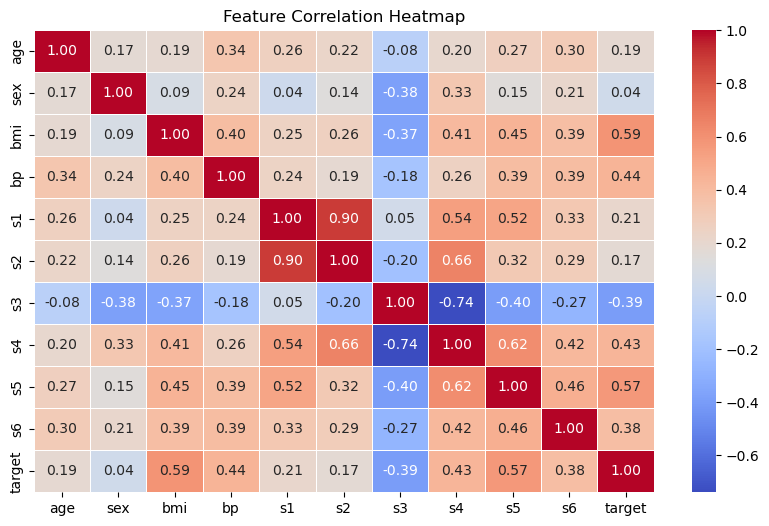

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

The target variable (disease progression) is strongly correlated with:
* s5 (serum triglycerides level) (0.57 correlation) → strongest predictor
* bmi (Body Mass Index) (0.39 correlation) → important factor
* bp (blood pressure) (0.38 correlation)
  
Weak correlations with sex and s1-s4 suggest they may be less important.<br>
No extreme multicollinearity, so no immediate need for PCA or feature selection.

* The target variable follows a skewed normal distribution.
* Could apply log transformation if a linear model was used, but Random Forest can handle it directly.

Based on our correlation analysis, the top 5 features correlated with target are:
* s5 (Serum triglycerides level) → 0.57 correlation
* bmi (Body Mass Index) → 0.39 correlation
* bp (Blood Pressure) → 0.38 correlation
* s4 (Serum HDL cholesterol) → 0.43 correlation
* s6 (Blood Sugar Level) → 0.38 correlation

In [29]:
# Selecting top 5 features
selected_features = ['s5', 'bmi', 'bp', 's4', 's6']
X = df[selected_features]
y = df['target']

### Splitting the dataset

In [31]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train the Random Forest Model

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

### Model Evaluation

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 3052.08
Root Mean Squared Error (RMSE): 55.25
Mean Absolute Error (MAE): 45.23
R² Score: 0.42


### Visualizing Model Performance

#### Actual vs. Predicted Values

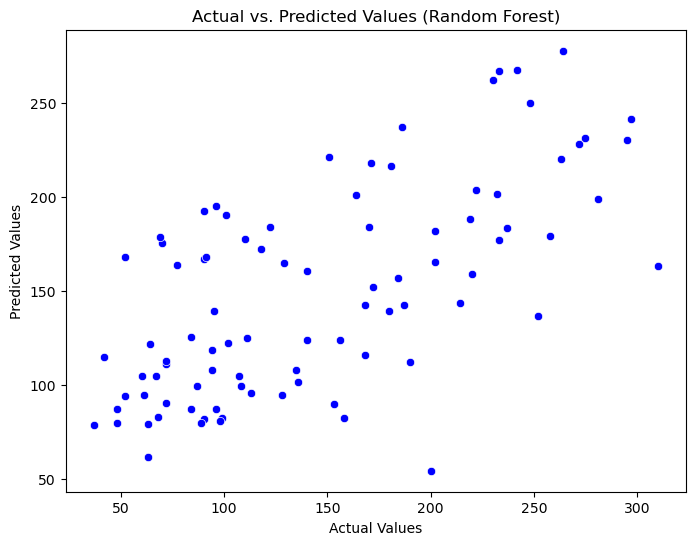

In [39]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Random Forest)")
plt.show()

#### Residual Plot

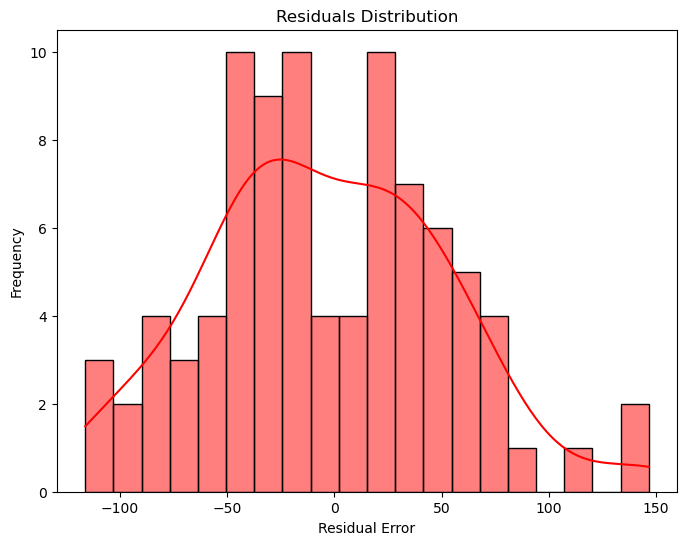

In [41]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color='red')
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

Observations:
* Wide spread of residuals → Indicates higher prediction errors.
* Some skewness (residuals are not perfectly symmetric) → Model may be underfitting.
* Higher variance → Suggests the model is making inconsistent errors.

### Hyperparameter Tuning Using RandomizedSearchCV

In [43]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
    'max_depth': [5, 10, 20, None],  # Max depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples per split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2']  # Number of features to consider
}

rf_regressor = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    rf_regressor, param_distributions=param_grid,
    n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}


### Train the Optimized Model

In [45]:
# Train Random Forest with the best hyperparameters
best_rf = RandomForestRegressor(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on test data
y_pred_optimized = best_rf.predict(X_test)

### Train the Optimized Model

In [47]:
# Compute evaluation metrics
mse_opt = mean_squared_error(y_test, y_pred_optimized)
rmse_opt = np.sqrt(mse_opt)
mae_opt = mean_absolute_error(y_test, y_pred_optimized)
r2_opt = r2_score(y_test, y_pred_optimized)

# Print optimized performance
print(f"Optimized Mean Squared Error (MSE): {mse_opt:.2f}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse_opt:.2f}")
print(f"Optimized Mean Absolute Error (MAE): {mae_opt:.2f}")
print(f"Optimized R² Score: {r2_opt:.2f}")

Optimized Mean Squared Error (MSE): 2703.80
Optimized Root Mean Squared Error (RMSE): 52.00
Optimized Mean Absolute Error (MAE): 42.76
Optimized R² Score: 0.49


### Performance Comparison (Before vs After Tuning)

In [49]:
print("\nPerformance Improvement:")
print(f"R² Score Before Tuning: {r2:.2f}")
print(f"R² Score After Tuning: {r2_opt:.2f}")
print(f"RMSE Before Tuning: {rmse:.2f}")
print(f"RMSE After Tuning: {rmse_opt:.2f}")


Performance Improvement:
R² Score Before Tuning: 0.42
R² Score After Tuning: 0.49
RMSE Before Tuning: 55.25
RMSE After Tuning: 52.00


### Visualizing Performance Improvement

#### Actual vs. Predicted Values (After Tuning)

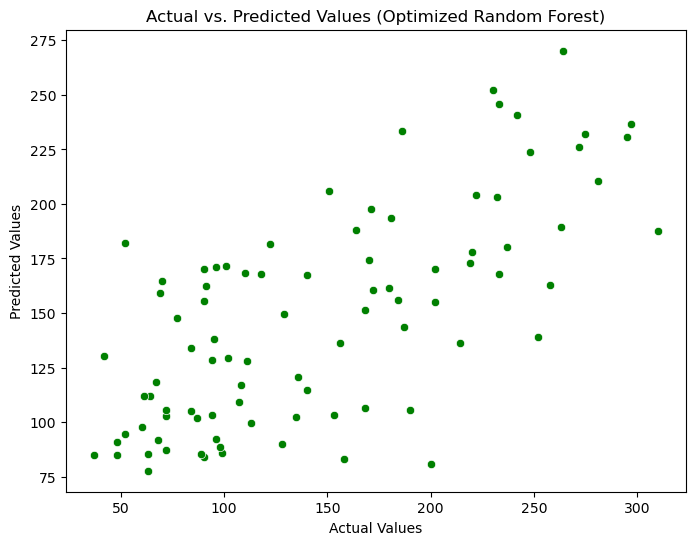

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_optimized, color='green')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Optimized Random Forest)")
plt.show()

#### Residual Plot (After Tuning)

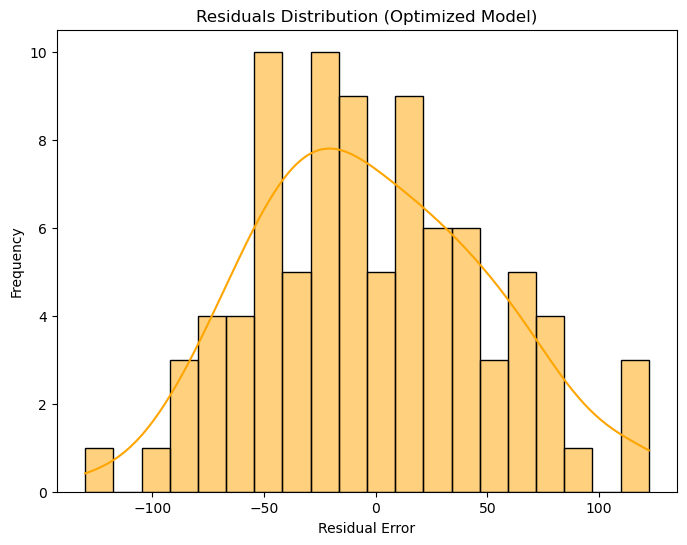

In [53]:
residuals_optimized = y_test - y_pred_optimized

plt.figure(figsize=(8,6))
sns.histplot(residuals_optimized, bins=20, kde=True, color='orange')
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Optimized Model)")
plt.show()

Observation:
* Narrower spread of residuals → Model predictions are more precise.
* More symmetric residual distribution → Less systematic bias in predictions.
* Reduced variance → Errors are more consistent and predictable.